# Modelo c dois diretorios pegando VGG16 como base


In [219]:
import os
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import numpy as np
import matplotlib.pyplot as plt


In [220]:

# Configurações de imagem e treinamento
data_base_path = 'C:/Users/User/Downloads/Imagens'
dir_train = os.path.join(data_base_path, 'train').replace(os.path.sep, '/')
dir_validation = os.path.join(data_base_path, 'validation').replace(os.path.sep, '/')
batch_size = 32
img_width, img_height = 180, 180
img_size = (img_width, img_height)
epochs = 20


In [221]:

# Carregamento dos conjuntos de dados de treinamento e validação
train_ds = tf.keras.utils.image_dataset_from_directory(
    dir_train,
    shuffle=True,
    image_size=img_size,
    batch_size=batch_size,
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    dir_validation,
    shuffle=True,
    image_size=img_size,
    batch_size=batch_size,
)


Found 34 files belonging to 3 classes.
Found 16 files belonging to 3 classes.


In [222]:

nomes_classes = train_ds.class_names
num_classes = len(nomes_classes)

val_ds_card = tf.data.experimental.cardinality(val_ds)
lotes_val_ds = val_ds_card // 3
test_ds = val_ds.take(lotes_val_ds)
val_ds = val_ds.skip(lotes_val_ds)

print('Validation Dataset Cardinality: %d' % tf.data.experimental.cardinality(val_ds))
print('Test Dataset Cardinality: %d' % tf.data.experimental.cardinality(test_ds))


Validation Dataset Cardinality: 1
Test Dataset Cardinality: 0


In [223]:

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)


In [224]:

# Base do modelo VGG16
base_model = tf.keras.applications.VGG16(input_shape=(img_width, img_height, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Congelando o modelo base

# Criando o modelo de rede neural
model = Sequential([
    layers.Rescaling(1./255, input_shape=(img_width, img_height, 3)),
    base_model,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:18: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_38 (Rescaling)        │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 5, 5, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_23 (Flatten)            │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 256)            │     3,277,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,992,515 (68.64 MB)

 Trainable params: 3,277,827 (12.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [227]:

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Treinando o modelo
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=[reduce_lr, early_stopping])


Epoch 1/20


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.6667 - loss: 1.4828 - val_accuracy: 0.5000 - val_loss: 2.0685 - learning_rate: 2.0000e-04
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.6667 - loss: 1.6347 - val_accuracy: 0.2500 - val_loss: 1.8384 - learning_rate: 2.0000e-04
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.5196 - loss: 1.7871 - val_accuracy: 0.2500 - val_loss: 1.6283 - learning_rate: 2.0000e-04
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.7255 - loss: 1.0101 - val_accuracy: 0.2500 - val_loss: 1.6030 - learning_rate: 2.0000e-04
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.6863 - loss: 1.0844 - val_accuracy: 0.2500 - val_loss: 1.6158 - learning_rate: 2.0000e-04
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.5196 - loss: 1.3959 - val_accuracy: 0.5000 - val_loss: 1.5831 - learning_rate: 2.0000e-04
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.7843 - loss: 0.7479 - val_accuracy: 0.5625 -

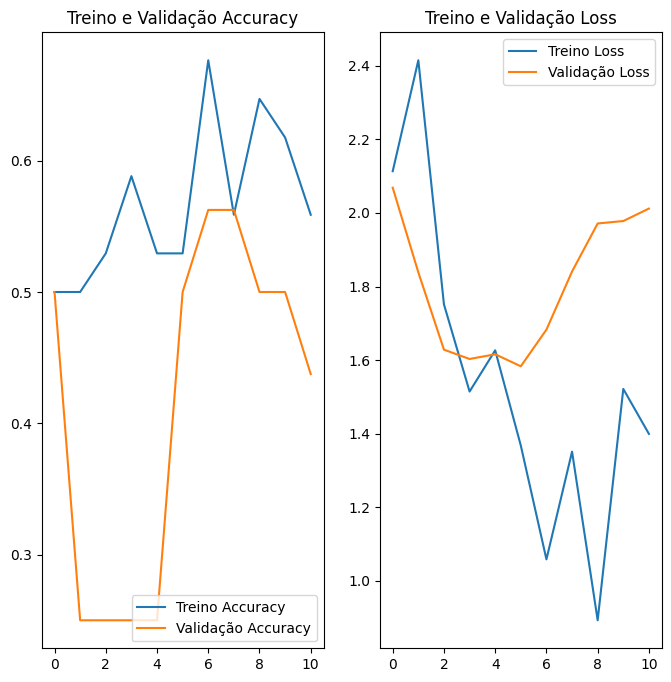

In [228]:

# Função para plotar os gráficos de treino e validação
def plotar_gf(history, epochs):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    faixa_epochs = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(faixa_epochs, acc, label='Treino Accuracy')
    plt.plot(faixa_epochs, val_acc, label='Validação Accuracy')
    plt.legend(loc='lower right')
    plt.title('Treino e Validação Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(faixa_epochs, loss, label='Treino Loss')
    plt.plot(faixa_epochs, val_loss, label='Validação Loss')
    plt.legend(loc='upper right')
    plt.title('Treino e Validação Loss')
    plt.show()

plotar_gf(history, epochs)


In [230]:

# Função para prever a classe de uma imagem
def previews(path_img, model, nomes_classes):
    img = tf.keras.utils.load_img(path_img, target_size=(img_height, img_width))
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Criando um batch

    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])

    print(f"Classificada como {nomes_classes[np.argmax(score)]} com uma accuracy de {100 * np.max(score):.2f}%.")



In [231]:
# Testando a previsão com uma imagem
previews(r'C:\Users\User\Desktop\modelo_classifier\imagens_para_teste\uniforme (13).jpg', model, nomes_classes)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 619ms/step
Classificada como Mediana com uma accuracy de 48.20%.
